In [1]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

In [2]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook


In [3]:
from tensorflow.keras import optimizers

In [4]:
%cd '/content/drive/MyDrive/kaggle'

/content/drive/MyDrive/kaggle


In [5]:
df = pd.read_csv("/content/drive/MyDrive/kaggle/Data_path_features.csv")

In [6]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
4950,-18.611181,-17.616535,-18.411484,-18.987421,-17.404621,-16.747272,-17.733749,-18.055027,-17.931210,-15.913172,-15.003449,-15.979334,-16.348255,-17.795094,-17.092600,-15.416254,-16.268023,-17.509769,-18.500113,-17.777544,-16.064751,-15.990108,-16.825844,-19.416613,-19.248117,-19.206270,-21.032600,-22.249826,-21.765230,-23.090590,-24.427376,-23.955061,-22.673870,-21.966145,-22.520149,-21.388805,-19.803690,-21.663492,-24.595623,-22.753239,...,-24.622999,-23.686852,-23.006695,-23.328550,-22.351040,-22.005341,-23.394726,-23.191683,-21.791996,-21.973999,-22.037476,-22.707808,-22.589994,-25.882610,-22.465931,-20.803608,-20.128231,-21.538298,-23.757799,-22.644869,-21.246086,-22.334455,-24.549614,-22.482368,-21.046780,-19.038082,-19.767479,-22.498535,-21.003120,-22.440336,-22.899403,-21.647814,-19.758650,-18.879402,-19.397379,-20.171659,-22.689241,-24.612816,-24.153774,-22.703135
3860,-13.719338,-16.901081,-23.111773,-21.208946,-22.597612,-27.656578,-25.874819,-24.519142,-25.615971,-25.860441,-25.289042,-26.233866,-29.301311,-25.713509,-25.167057,-24.284536,-20.659727,-20.691711,-17.825060,-17.277483,-17.848997,-17.878527,-18.963680,-20.663626,-21.379459,-22.922880,-24.024254,-26.710335,-28.861376,-30.579754,-29.329121,-28.887737,-29.473236,-31.177673,-30.529715,-27.759480,-24.662609,-23.941545,-25.544828,-25.882589,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9761,-1.533946,-4.030604,-9.614023,-12.045175,-9.992991,-11.926253,-14.008464,-13.561556,-14.024568,-15.151946,-14.091325,-14.444936,-15.080296,-13.436305,-10.627333,-11.366418,-9.941072,-8.282315,-7.593579,-9.596803,-12.209168,-10.878652,-9.996443,-9.153242,-8.455300,-7.230552,-7.610101,-8.270742,-8.250637,-6.913833,-6.073126,-7.495994,-8.007623,-7.892565,-8.418385,-9.888177,-12.714469,-11.961720,-11.708016,-10.882406,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7620,-4.531078,-3.933793,-4.567834,-5.871509,-5.282474,-6.490458,-8.156469,-9.188803,-8.681726,-8.212408,-10.091819,-10.203221,-11.894746,-14.165041,-12.755168,-11.690284,-11.109209,-9.576483,-9.684600,-8.298368,-7.677458,-6.155096,-5.003188,-5.831573,-6.692802,-6.053375,-6.739268,-8.264972,-9.381650,-10.108953,-11.597776,-12.491655,-11.854798,-12.057825,-8.097494,-7.696414,-11.342515,-11.067337,-8.617125,-9.130977,...,-19.450392,-18.572659,-18.351620,-19.521305,-18.855267,-16.842207,-17.038740,-17.506563,-18.298649,-17.981977,-16.775129,-16.381832,-17.170134,-20.650728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11586,-20.621704,-21.587505,-20.563646,-20.703461,-21.205717,-18.608528,-18.446669,-16.211843,-14.257651,-15.160404,-16.223400,-17.730740,-18.256369,-16.877583,-16.413738,-17.221680,-16.712870,-13.694067,-12.639807,-14.987528,-16.563732,-18.237068,-18.482103,-18.212257,-16.454220,-16.483700,-19.338146,-20.670725,-20.005056,-16.037767,-14.584289,-13.579376,-13.083269,-14.677512,-13.112721,-13.186565,-12.656782,-13.191530,-14.0

In [7]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
4950,0.187061,0.303830,0.437761,0.388264,0.497932,0.541479,0.460090,0.431081,0.434383,0.579951,0.642771,0.566986,0.533356,0.422135,0.466129,0.585049,0.517708,0.425094,0.347697,0.399370,0.523183,0.527498,0.462506,0.270701,0.279991,0.283563,0.145378,0.052626,0.083784,-0.016301,-0.118830,-0.084446,0.005868,0.057181,0.011602,0.092895,0.207948,0.063391,-0.171061,-0.032584,...,-1.007438,-0.933479,-0.871044,-0.921475,-0.847683,-0.807560,-0.935576,-0.911144,-0.830915,-0.834381,-0.829219,-0.896774,-0.880639,-1.091292,-0.880570,-0.765047,-0.712700,-0.820002,-0.959708,-0.875309,-0.800564,-0.863728,-0.993725,-0.873860,-0.771624,-0.628735,-0.696994,-0.860163,-0.753168,-0.861100,-0.882224,-0.813218,-0.692869,-0.630748,-0.678032,-0.720307,-0.863235,-0.985900,-0.969144,-0.878309
3860,0.529310,0.355835,0.088777,0.223748,0.113834,-0.265709,-0.140652,-0.045045,-0.131374,-0.152053,-0.114784,-0.188176,-0.418265,-0.160002,-0.127049,-0.065847,0.194944,0.190919,0.397329,0.436171,0.391761,0.388366,0.305087,0.178717,0.122810,0.009231,-0.075418,-0.276586,-0.438801,-0.567948,-0.479871,-0.448339,-0.497108,-0.626413,-0.585694,-0.385727,-0.160704,-0.111361,-0.244741,-0.279203,...,0.760025,0.758759,0.758447,0.733704,0.731298,0.729245,0.702776,0.702614,0.677715,0.676531,0.675412,0.649613,0.648145,0.646650,0.624055,0.623299,0.624114,0.605191,0.603481,0.603704,0.586630,0.585692,0.586020,0.572314,0.573280,0.574489,0.554447,0.554641,0.555505,0.539711,0.539434,0.525593,0.525147,0.526374,0.511337,0.511451,0.512173,0.500577,0.495529,0.491118
9761,1.381837,1.291359,1.090949,0.902376,1.046133,0.898190,0.734984,0.762056,0.721992,0.635968,0.709951,0.679982,0.626509,0.742579,0.941091,0.882291,0.982700,1.104190,1.149581,1.001410,0.807174,0.904094,0.965385,1.027758,1.075933,1.167520,1.136010,1.084363,1.079046,1.175269,1.233065,1.129772,1.090788,1.101590,1.063210,0.956925,0.745816,0.807625,0.829314,0.902936,...,0.760025,0.758759,0.758447,0.733704,0.731298,0.729245,0.702776,0.702614,0.677715,0.676531,0.675412,0.649613,0.648145,0.646650,0.624055,0.623299,0.624114,0.605191,0.603481,0.603704,0.586630,0.585692,0.586020,0.572314,0.573280,0.574489,0.554447,0.554641,0.555505,0.539711,0.539434,0.525593,0.525147,0.526374,0.511337,0.511451,0.512173,0.500577,0.495529,0.491118
7620,1.172149,1.298396,1.465616,1.359569,1.394545,1.300389,1.166812,1.084139,1.115335,1.146637,1.004523,0.992349,0.860541,0.689005,0.784772,0.858520,0.896849,1.008946,0.995842,1.096965,1.140966,1.252110,1.333060,1.272774,1.205913,1.254411,1.200281,1.084789,0.995754,0.939918,0.826143,0.761232,0.806198,0.792483,1.087139,1.121589,0.849908,0.876234,1.069238,1.040963,...,-0.636143,-0.568110,-0.541340,-0.651348,-0.600725,-0.446978,-0.490462,-0.515554,-0.589076,-0.559893,-0.469927,-0.465979,-0.513849,-0.739986,0.624055,0.623299,0.624114,0.605191,0.603481,0.603704,0.586630,0.585692,0.586020,0.572314,0.573280,0.574489,0.554447,0.554641,0.555505,0.539711,0.539434,0.525593,0.525147,0.526374,0.511337,0.511451,0.512173,0.500577,0.495529,0.491118
11586,0.046399,0.015190,0.277969,0.261182,0.216785,0.403764,0.407483,0.566844,0.704832,0.635346,0.552919,0.438009,0.393173,0.489587,0.516001,0.452538,0.485014,0.705911,0.778565,0.604694,0.486430,0.361949,0.340548,0.359538,0.486034,0.484523,0.270435,0.169173,0.213409,0.503205,0.606170,0.680989,0.715323,0.598075,0.713140,0.709120,0.750193,0.713285,0.646436,0.579271,...,0.760025,0.758759,0.758447,0.733704,0.731298,0.729245,0.702776,0.702614,0.677715,0.676531,0.675412,0.649613,0.648145,0.646650,0.624055,0.623299,0.624114,0.605191,0.603481,0.603704,0.586630,0.585692,0.586020,0.572314,0.573280,0.574489,0.554447,0.554641,0.555505,0.539711,0.539434,0.525593,0.525147,0.526374,0.511337,0.511451,0.512173,0.500577,0.495529,0.49

In [8]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(9121, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [9]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(9121, 216, 1)

In [10]:
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


accuracy: 42.75%


In [14]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

191/191 [==============================] - 14s 75ms/step


array([2, 3, 9, ..., 8, 4, 0])

In [16]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,male_sad,female_disgust
171,female_neutral,female_sad
172,male_angry,female_angry
173,female_disgust,female_disgust
174,male_angry,male_angry
175,female_fear,female_happy
176,male_happy,male_angry
177,female_fear,female_fear
178,female_happy,female_fear
179,female_neutral,female_neutral


In [17]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

0.4274909569220651


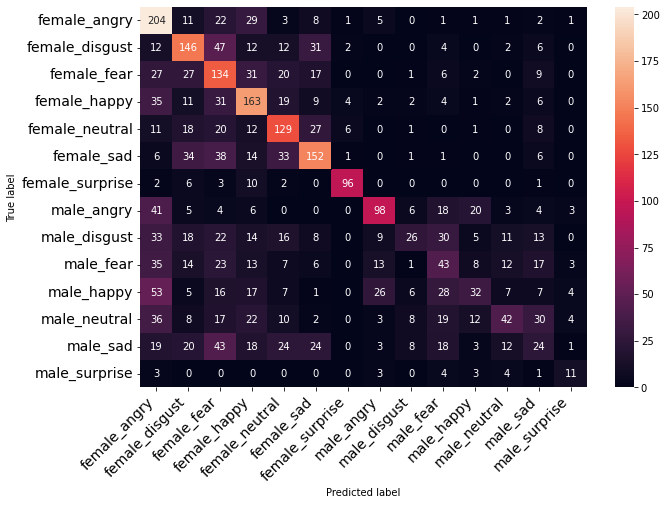

In [18]:
# Get the predictions file 
'''finaldf = pd.read_csv("Predictions.csv")'''
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [19]:
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.39      0.71      0.51       289
 female_disgust       0.45      0.53      0.49       274
    female_fear       0.32      0.49      0.39       274
   female_happy       0.45      0.56      0.50       289
 female_neutral       0.46      0.55      0.50       233
     female_sad       0.53      0.53      0.53       286
female_surprise       0.87      0.80      0.83       120
     male_angry       0.60      0.47      0.53       208
   male_disgust       0.43      0.13      0.20       205
      male_fear       0.24      0.22      0.23       195
     male_happy       0.36      0.15      0.22       209
   male_neutral       0.44      0.20      0.27       213
       male_sad       0.18      0.11      0.14       217
  male_surprise       0.41      0.38      0.39        29

       accuracy                           0.43      3041
      macro avg       0.44      0.42      0.41      3041
   weighted avg       0.43   

0.5210491695444828


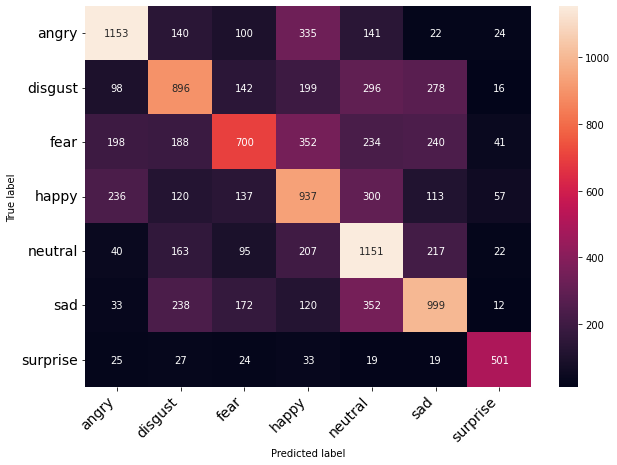

In [ ]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)
